## Exploratory Analysis of Reproduced Results

In [1]:
from ast import literal_eval
import os
import pandas as pd
from glob import glob
import numpy as np
from sklearn.metrics import classification_report
import torchvision
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import plot 
from matplotlib import pyplot
%matplotlib inline

In [2]:
search_path = "./"
file_extension = "*.csv"

dfs = []
[dfs.append(pd.read_csv(file, index_col=0))
 for path, subdir, files in os.walk(search_path)
 for file in glob(os.path.join(path, file_extension))]

df_orig = pd.concat(dfs, ignore_index=True)
df_orig['Accuracy'] = df_orig['Accuracy'].apply(lambda x: x*100)
df_orig['Original_CI'] = df_orig.Original_CI.apply(lambda x: literal_eval(x))
df_orig['Orig_CI_Low'], df_orig['Orig_CI_Hi'] = zip(*df_orig.Original_CI)

In [5]:
df_orig

,Model,Testset,Epoch,Loss,Accuracy,Original_Accuracy,Original_CI,Orig_CI_Low,Orig_CI_Hi
0,resnext_29_4x64d,cifar10,100,0.6746,80.19,96.4,"(96.0, 96.7)",96.0,96.7
1,resnext_29_4x64d,cifar10,200,0.2311,93.21,96.4,"(96.0, 96.7)",96.0,96.7
2,resnext_29_4x64d,cifar10,300,0.1517,95.35,96.4,"(96.0, 96.7)",96.0,96.7
3,wrn_28_10,cifar10,100,0.2299,93.11,95.9,"(95.5, 96.3)",95.5,96.3
4,wrn_28_10,cifar10,200,0.1760,95.78,95.9,"(95.5, 96.3)",95.5,96.3
5,densenet_BC_100_12,cifar10,100,0.3681,88.75,95.5,"(95.1, 95.9)",95.1,95.9
6,densenet_BC_100_12,cifar10,200,0.2279,94.56,95.5,"(95.1, 95.9)",95.1,95.9
7,densenet_BC_100_12,cifar10,300,0.2223,94.84,95.5,"(95.1, 95.9)",95.1,95.9
8,resnet_basic_32,cifar10,100,0.3604,91.70,92.5,"(92.0, 93.0)",92.0,93.0
9,resnet_basic_32,cifar10,160,0.4011,92.32,92.5,"(92.0, 93.0)",92.0,93.0


#### Visualize the delta between our reproduced result and the original result published for the respective model.

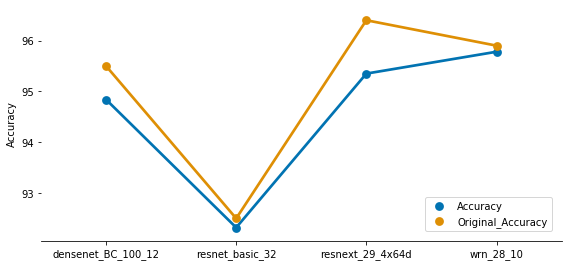

In [6]:
# Get accuracy score of last epoch for each model type
final_score = df_orig[df_orig.groupby(['Model'])['Epoch'].transform(max) == df_orig['Epoch']]

final_score_subset = final_score[['Model', 'Accuracy', 'Original_Accuracy']].sort_values(by=['Model'])
                                 #'Orig_CI_Low', 'Orig_CI_Hi']]

fss_melt = final_score_subset.melt('Model', var_name='cols',  value_name='vals')
g = sns.catplot(x="Model", y="vals", hue='cols', data=fss_melt, kind='point', 
                height=4, aspect=2, palette="colorblind",legend_out=False)

(g.set_axis_labels("", "Accuracy")
  .set_xticklabels(rotation=0)
  .despine(left=True))  
g.add_legend(loc='lower right', borderaxespad=1)
pass

#### Do our models seem to error in the same way?

In [7]:
# Retrieve the official labels of the CIFAR10 test dataset
testset = torchvision.datasets.CIFAR10(root='../../data/cifar10/', train=False,
                                       download=True)
test_labels = testset.targets

# Return a dataframe that contains the classification report for the predictions
classes = ['0 airplane', '1 automobile', '2 bird', '3 cat', '4  deer', '5 dog', '6 frog', 
           '7 horse', '8 ship', '9 truck']

# Confirm that when we compare these labels to our guesses, we get the accuracy score.
def confirm_score(zfile):
    print("\nAccuracy:", zfile['acc'])
    print(" -> Sanity Check:", np.sum(test_labels == zfile['labels']), "of", len(test_labels), "correct\n")
    
    # Examine the classes to see if the model is balanced in its accuracy across all labels 
    report = classification_report(test_labels, zfile['labels'], target_names=classes, output_dict=True)
    print(pd.DataFrame(report).transpose())


Files already downloaded and verified


In [11]:
number_to_analyze = 20

def error_by_r_score(zfile):
    images_to_print = []
    
    # Determine the probability we associatd with our predicted label
    pp_max = np.max(zfile['probs'], axis=1)

    # Retrieve the model's predicted probability of the correct label
    pp_correct = zfile['probs'][range(zfile['probs'].shape[0]), test_labels]

    # Calculate the R ratio for each document
    r = pp_max/pp_correct

    # Retrieve the row numbers where the R score is the highest
    max_r_value_indexes = r.argsort()[-1 * number_to_analyze:]

    for mi in max_r_value_indexes:
        print("-- R Ratio:", r[mi], " ( index", mi, ")\n   Guessed Label:", zfile['labels'][mi], 
              "\n   Correct Label:", test_labels[mi], "\n   Class Probs:", zfile['probs'][mi], "\n")
        img=Image.fromarray(testset.data[mi])
        images_to_print.append(img)
        


    # Print the misclassified images
    fig = plt.figure(figsize=(16, 4))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(2, 10),  
                     axes_pad=0.1,  
                     )

    for ax, im in zip(grid, images_to_print):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        
    return max_r_value_indexes

#### Densenet 

In [12]:
output = './densenet_BC_100_12/predictions_300.npz'
npzfile = np.load(output)
confirm_score(npzfile)


Accuracy: 0.9484
 -> Sanity Check: 9484 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.951244  0.9560  0.953616   1000.0000
1 automobile   0.971087  0.9740  0.972541   1000.0000
2 bird         0.955533  0.9240  0.939502   1000.0000
3 cat          0.899288  0.8840  0.891578   1000.0000
4  deer        0.937683  0.9630  0.950173   1000.0000
5 dog          0.898354  0.9280  0.912937   1000.0000
6 frog         0.966000  0.9660  0.966000   1000.0000
7 horse        0.983673  0.9640  0.973737   1000.0000
8 ship         0.954769  0.9710  0.962816   1000.0000
9 truck        0.968528  0.9540  0.961209   1000.0000
accuracy       0.948400  0.9484  0.948400      0.9484
macro avg      0.948616  0.9484  0.948411  10000.0000
weighted avg   0.948616  0.9484  0.948411  10000.0000


-- R Ratio: 75146.43  ( index 5830 )
   Guessed Label: 3 
   Correct Label: 5 
   Class Probs: [4.6590742e-10 3.4380457e-07 5.7846825e-09 9.9998629e-01 1.5234178e-09
 1.3307170e-05 4.5507040e-10 1.3015530e-09 3.9456743e-10 7.3355602e-09] 

-- R Ratio: 91149.44  ( index 1969 )
   Guessed Label: 9 
   Correct Label: 1 
   Class Probs: [5.6721942e-06 1.0966472e-05 9.3598924e-09 1.4922101e-08 3.9816868e-08
 1.4080071e-07 8.2582727e-07 3.9247659e-04 2.1952026e-06 9.9958771e-01] 

-- R Ratio: 97676.484  ( index 5511 )
   Guessed Label: 6 
   Correct Label: 3 
   Class Probs: [8.0893547e-10 8.6297734e-07 5.7008652e-05 1.0237106e-05 5.5011050e-08
 3.0940381e-08 9.9992454e-01 1.0574610e-08 2.1037634e-07 7.1299728e-06] 

-- R Ratio: 128654.875  ( index 8728 )
   Guessed Label: 5 
   Correct Label: 6 
   Class Probs: [7.92525101e-10 3.39370246e-07 1.15334814e-07 4.70935833e-03
 3.46262453e-07 9.95281160e-01 7.73605461e-06 4.53010855e-08
 2.65394675e-07 5.96678660e-07] 

-- R Ratio: 152582.98  ( i

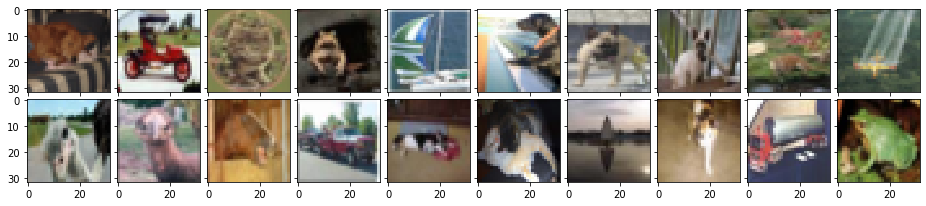

In [13]:
densenet_errors = error_by_r_score(npzfile)

In [14]:
densenet_errors

array([5830, 1969, 5511, 8728, 1772, 2525, 2804, 4614, 4965,  378, 7657,
       2592, 6151, 9227, 7509, 9431, 5548, 7099, 6741, 2405])

#### Resnet_basic_32 

In [15]:
output = './resnet_basic_32/predictions_160.npz'
npzfile = np.load(output)
confirm_score(npzfile)


Accuracy: 0.9232
 -> Sanity Check: 9232 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.918208  0.9430  0.930439   1000.0000
1 automobile   0.965966  0.9650  0.965483   1000.0000
2 bird         0.898899  0.8980  0.898449   1000.0000
3 cat          0.848423  0.8340  0.841150   1000.0000
4  deer        0.916091  0.9280  0.922007   1000.0000
5 dog          0.883249  0.8700  0.876574   1000.0000
6 frog         0.951613  0.9440  0.947791   1000.0000
7 horse        0.948847  0.9460  0.947421   1000.0000
8 ship         0.953047  0.9540  0.953523   1000.0000
9 truck        0.946215  0.9500  0.948104   1000.0000
accuracy       0.923200  0.9232  0.923200      0.9232
macro avg      0.923056  0.9232  0.923094  10000.0000
weighted avg   0.923056  0.9232  0.923094  10000.0000


-- R Ratio: 1265153.5  ( index 2525 )
   Guessed Label: 0 
   Correct Label: 5 
   Class Probs: [7.6998925e-01 2.1350957e-01 6.3176936e-05 5.2736239e-05 1.1055653e-09
 6.0861333e-07 4.6001592e-06 6.1802695e-08 1.6369035e-02 1.0924998e-05] 

-- R Ratio: 1275869.2  ( index 8943 )
   Guessed Label: 4 
   Correct Label: 7 
   Class Probs: [4.4790840e-10 2.5577702e-12 5.1414622e-07 6.2953922e-07 9.9959546e-01
 4.0262527e-04 7.4946729e-11 7.8346227e-07 4.2929424e-10 9.5574482e-10] 

-- R Ratio: 1291772.2  ( index 4036 )
   Guessed Label: 0 
   Correct Label: 7 
   Class Probs: [9.7658509e-01 1.5669994e-02 2.3682215e-04 6.4156469e-05 3.1097993e-06
 1.1725832e-07 8.3483300e-09 7.5600411e-07 7.3858546e-03 5.4094147e-05] 

-- R Ratio: 1489369.4  ( index 1779 )
   Guessed Label: 5 
   Correct Label: 3 
   Class Probs: [5.99523426e-12 1.89646059e-11 1.27360655e-08 6.71424630e-07
 1.27862316e-08 9.99999285e-01 1.36353345e-10 1.00111634e-10
 1.84187474e-11 1.05280173e-09] 

-- R Ratio: 2282305.0  ( 

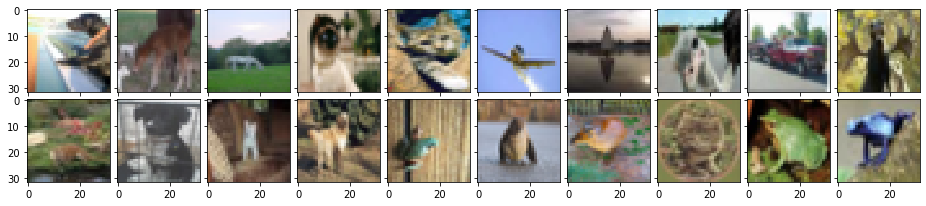

In [16]:
resnet_errors = error_by_r_score(npzfile)

#### Resnext_29_4x64 

In [17]:
output = './resnext_29_4x64/predictions_300.npz'
npzfile = np.load(output)
confirm_score(npzfile)


Accuracy: 0.9535
 -> Sanity Check: 9535 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.960080  0.9620  0.961039   1000.0000
1 automobile   0.980981  0.9800  0.980490   1000.0000
2 bird         0.944779  0.9410  0.942886   1000.0000
3 cat          0.892108  0.8930  0.892554   1000.0000
4  deer        0.942495  0.9670  0.954590   1000.0000
5 dog          0.930612  0.9120  0.921212   1000.0000
6 frog         0.963257  0.9700  0.966617   1000.0000
7 horse        0.983707  0.9660  0.974773   1000.0000
8 ship         0.970090  0.9730  0.971543   1000.0000
9 truck        0.967131  0.9710  0.969062   1000.0000
accuracy       0.953500  0.9535  0.953500      0.9535
macro avg      0.953524  0.9535  0.953477  10000.0000
weighted avg   0.953524  0.9535  0.953477  10000.0000


-- R Ratio: 1095.5309  ( index 9812 )
   Guessed Label: 8 
   Correct Label: 3 
   Class Probs: [7.0456263e-05 3.3270409e-03 1.2921165e-03 9.0628595e-04 4.0867511e-05
 1.0874068e-03 1.4056497e-04 1.3924873e-04 9.9286425e-01 1.3175572e-04] 

-- R Ratio: 1107.9537  ( index 4744 )
   Guessed Label: 0 
   Correct Label: 6 
   Class Probs: [9.95249867e-01 1.29135873e-03 8.90829426e-04 1.89205588e-04
 1.01792291e-04 1.17512245e-04 8.98277445e-04 2.04279975e-04
 7.22305384e-04 3.34476412e-04] 

-- R Ratio: 1115.0187  ( index 1325 )
   Guessed Label: 4 
   Correct Label: 2 
   Class Probs: [3.28808960e-06 1.22339600e-06 8.96004960e-04 1.27644043e-05
 9.99062240e-01 6.96468351e-06 1.16671545e-05 3.12349380e-06
 1.59925014e-06 1.12225302e-06] 

-- R Ratio: 1121.1064  ( index 3615 )
   Guessed Label: 2 
   Correct Label: 6 
   Class Probs: [7.2504424e-02 1.6578172e-03 9.1896445e-01 1.9981461e-03 2.6127764e-03
 8.7119377e-04 8.1969419e-04 2.3666781e-04 1.6367521e-04 1.7125196e-04] 

-- R Ratio: 12

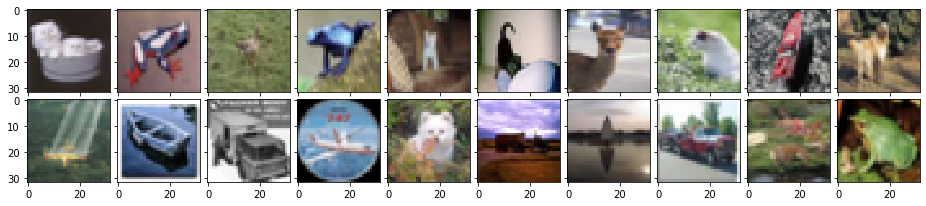

In [18]:
resnext_errors_4 = error_by_r_score(npzfile)

#### Resnext_29_4x64 

In [19]:
output = './wrn_28_10/predictions_200.npz'
npzfile = np.load(output)
confirm_score(npzfile)


Accuracy: 0.9578
 -> Sanity Check: 9578 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.953876  0.9720  0.962853   1000.0000
1 automobile   0.972305  0.9830  0.977623   1000.0000
2 bird         0.963115  0.9400  0.951417   1000.0000
3 cat          0.905584  0.8920  0.898741   1000.0000
4  deer        0.956565  0.9690  0.962742   1000.0000
5 dog          0.915187  0.9280  0.921549   1000.0000
6 frog         0.971202  0.9780  0.974589   1000.0000
7 horse        0.990798  0.9690  0.979778   1000.0000
8 ship         0.972973  0.9720  0.972486   1000.0000
9 truck        0.976954  0.9750  0.975976   1000.0000
accuracy       0.957800  0.9578  0.957800      0.9578
macro avg      0.957856  0.9578  0.957775  10000.0000
weighted avg   0.957856  0.9578  0.957775  10000.0000


-- R Ratio: 3762.1255  ( index 3059 )
   Guessed Label: 3 
   Correct Label: 5 
   Class Probs: [2.44224764e-04 1.10317065e-04 1.47068733e-03 9.95518446e-01
 4.70431463e-04 2.64615956e-04 1.47434970e-04 1.44598703e-03
 8.59400097e-05 2.41944290e-04] 

-- R Ratio: 4424.7915  ( index 6151 )
   Guessed Label: 3 
   Correct Label: 7 
   Class Probs: [1.34861970e-04 1.23037738e-04 5.16728905e-04 9.94561732e-01
 1.12286210e-03 3.05154105e-03 1.19098724e-04 2.24770294e-04
 6.59051730e-05 7.94818770e-05] 

-- R Ratio: 5077.1484  ( index 810 )
   Guessed Label: 2 
   Correct Label: 5 
   Class Probs: [6.55545853e-04 8.80686275e-05 9.97089446e-01 1.38246850e-03
 1.07513195e-04 1.96387686e-04 1.44154081e-04 2.60882516e-04
 3.27359339e-05 4.28031672e-05] 

-- R Ratio: 5107.7593  ( index 2895 )
   Guessed Label: 5 
   Correct Label: 7 
   Class Probs: [3.6476056e-05 3.8681275e-05 8.2377810e-05 4.0284777e-04 8.3513070e-05
 9.9902332e-01 7.0702794e-05 1.9558935e-04 3.3699529e-05 3.2777974e-05] 

-- R

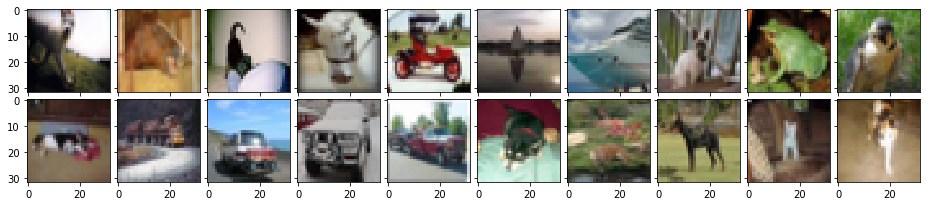

In [20]:
wrn_28_10_errors = error_by_r_score(npzfile)

### Comparison

The number of common misclassifications across all models: 4
{9227, 5548, 2405, 4965}


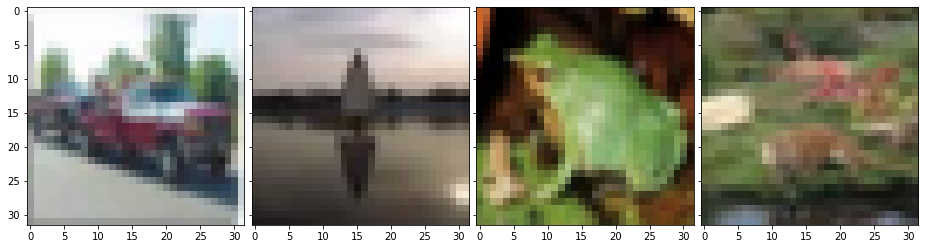

In [21]:
# View intersection of errors
intersect = set(resnext_errors_4) & set(resnet_errors) & set(densenet_errors) & set(wrn_28_10_errors)
print("The number of common misclassifications across all models:", len(intersect))
print(intersect)

# View errors 
df_errors = pd.DataFrame({'resnext_29_4x64' : resnext_errors_4,
                          'resnet_errors' : resnet_errors,
                          'densenet_errors' : densenet_errors,
                          'wrn_28_10_errors' : wrn_28_10_errors})

images_to_print = []

for i in intersect:
    img=Image.fromarray(testset.data[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect)), axes_pad=0.1,  )

for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [22]:
df = pd.DataFrame()

for m, me in [('resnet_errors', resnet_errors), ('resnext_29_4x64', resnext_errors_4), 
              ('densenet_errors', densenet_errors), ('wrn_28_10_errors', wrn_28_10_errors)]:
    for e in me:
        df.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df.fillna(False, inplace=True)
cols = df.columns
df.reset_index(inplace=True)
df

,index,2525,8943,4036,1779,1905,5454,5548,7657,9227,2785,4965,2590,4740,4528,1935,9704,1765,5511,2405,3615,9812,4744,1325,810,1217,3052,1685,378,7559,5455,8743,4275,3957,5830,1969,8728,1772,2804,4614,2592,6151,7509,9431,7099,6741,3059,2895,665,384,2495,7311,4276,128,1506
0,resnet_errors,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,resnext_29_4x64,False,False,False,False,False,False,True,False,True,False,True,False,True,True,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,densenet_errors,True,False,False,False,False,False,True,True,True,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False
3,wrn_28_10_errors,False,False,False,False,False,False,True,False,True,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,True,False,True,False,True,True,True,True,True,True,True,True,True


In [23]:
whoknows = df.groupby(list(cols))['index'].count()

wk2 = df.groupby(['9227', '2785', '3957'])['index'].count()
wk2

9227  2785   3957 
True  False  False    2
             True     1
      True   False    1
Name: index, dtype: int64

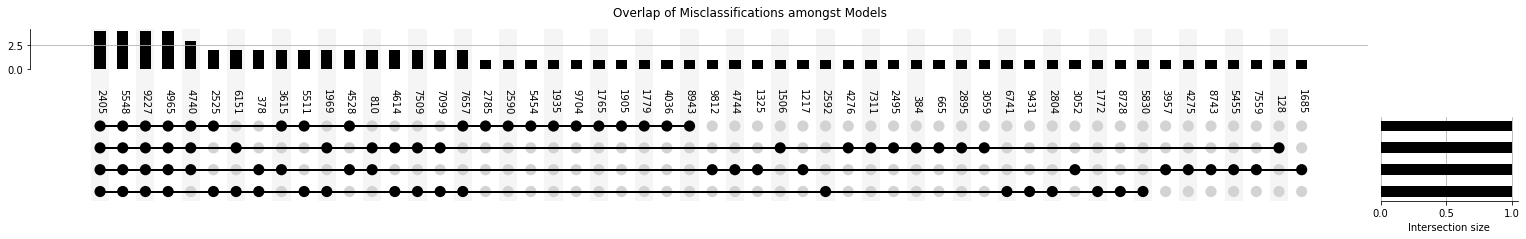

In [24]:
plot(whoknows, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of Misclassifications amongst Models')
pyplot.show()  